In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [2]:
### Load datamodel from .p file
run_name = 'run1_probe'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\09\run1_probe\run1_probe-datamodel.p


In [3]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [100,102,104,106,108,110,112,114,116,118,120]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,5,10]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)


mol_freq_list = [6,5,5.5,6,6.5,7,7.5]
num_frames = len(mol_freq_list) + 3

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

30 points
10 frames
11 tweezers
5677 shots
189 complete loops


In [4]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))

counts_array = counts_array[:,:,:,:,19:]
num_loops = num_loops - 19
print(counts_array.shape)

(10, 3, 10, 11, 170)


c:\python37-32\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


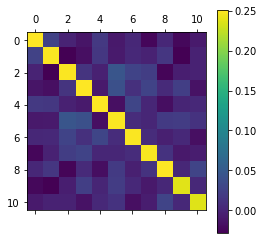

mean_in_theory:5.5, std_in_theory:1.6583123951777
mean:5.658823529411765, std:1.7560178290430184
[0, 0]
[1, 1]
[2, 7]
[3, 12]
[4, 23]
[5, 30]
[6, 44]
[7, 28]
[8, 18]
[9, 5]
[10, 2]
[11, 0]


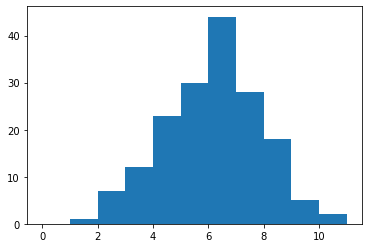

In [5]:
show_plot = False
# zeropeakHWFMper = 1.5
zeropeakHWFMper = 3
num_avg = 50 # number of loops to put in moving average

# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),num_loops))



ref_counts = counts_array[num_frames-2,:,:,:,:]
base = np.nanmean(ref_counts,3)

upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 3):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    
    for probe_att_counter, probe_att in enumerate(probe_att_list):
        for pzt_para_counter, pzt_para in enumerate(pzt_para_list):
            if show_plot == True:
                fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
                fig.suptitle(f'counts histogram - mol_freq={mol_freq} - probe_att={probe_att} - pzt_para={pzt_para} - frame_{frame_num + 1}')
                    
                for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                    bins=50
                    ax[0,tweezer_freq_counter].hist(counts_1[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                    ax[0,tweezer_freq_counter].hist(ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                    n, bins, patches = \
                    ax[0,tweezer_freq_counter].hist(counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                    ax[0,tweezer_freq_counter].hist(counts_postpost_selected[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                    ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    ax[0,tweezer_freq_counter].axvline(upper_threshold[probe_att_counter,pzt_para_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                    scatter_range = range(num_loops)
                    ax[1,tweezer_freq_counter].scatter(scatter_range, counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='r')
                    ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='b')
                    ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                    ax[1,tweezer_freq_counter].set_ylabel('photon counts')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                plt.show()
    
    
    has_atom[frame_num,:,:,:,:] = np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:,:], axis = 2)
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness[:,:,:,:,10:],4)
cav_brightness_sigma = np.nanstd(cav_brightness[:,:,:,:,10:],4)
cav_fidelity_mean = np.nanmean(cav_fidelity[:,:,:,:,10:],4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,:,start_temp:end_temp],4)

covariance_matrix = np.zeros((num_tweezers,num_tweezers))
for ii in range(num_tweezers):
    for jj in range(num_tweezers):
        covariance_matrix[ii,jj] = np.cov(has_atom[0,0,0,ii,:],has_atom[0,0,0,jj,:])[0,1]
plt.matshow(covariance_matrix)
plt.colorbar()
plt.show()

bins=11
plt.hist(atom_number[0,0,0,:],bins=bins,range=(0,bins))
print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
print(f"mean:{np.mean(atom_number[0,0,0,:])}, std:{np.std(atom_number[0,0,0,:])}")
for number_atom in range(num_tweezers+1):
    print([number_atom, np.count_nonzero(atom_number[0,0,0,:]==number_atom)])

In [6]:
# PICK ONE probe_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: probe_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 

# num_tweezers = 2



# for probe_att_counter in range(len(probe_att_list)):
#     fig, axs = plt.subplots(len(mol_freq_list), 2+num_tweezers,  figsize=(12, len(mol_freq_list)*6))
#     for mol_counter in range(len(mol_freq_list)):
#         axs[mol_counter,0].set_xlabel('pzt_para')
#         axs[mol_counter,0].set_ylabel('brightness')
#         axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')        
#         axs[mol_counter,0].tick_params(axis='y')
#         for tweezer_counter in range(num_tweezers):
#             axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness_mean[mol_counter, probe_att_counter, :, tweezer_counter], \
#                 yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
#             for loop in range(0,num_loops,1):
# #                 axs[mol_counter,1].plot(np.array(pzt_para_list),np.nanmean(cav_brightness[mol_counter,probe_att_counter,:,tweezer_counter,loop:(loop+25)],1))
#                 axs[mol_counter,1].plot(np.array(pzt_para_list),cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,loop])
#             axs[mol_counter,2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,:]), aspect = 0.25)
#         axs[mol_counter,0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

In [7]:
# using outside tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and probe att. 
outside_tweezer_counter = 0
molasses_intensity_list = [0.97512614, 0.98709936, 0.96621564, 0.99082936, 1. ,        0.93898526,
0.9479187,  0.90025779, 0.89672007, 0.88659351, 0.85702366]

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the probe mode. 

bg_brightness_mean = np.zeros(len(mol_freq_list))
bg_brightness_sigma = np.zeros(len(mol_freq_list))
bg_brightness_mov_avg = np.zeros((len(mol_freq_list), num_loops))
bg_brightness_mov_sigma = np.zeros((len(mol_freq_list), num_loops))

cav_brightness_mov_avg_normalized = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
# cav_brightness_mov_sigma_normalized = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))


for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_brightness_mean[mol_counter] = np.nanmean(cav_brightness_mean[mol_counter, :, :, outside_tweezer_counter])
        bg_brightness_sigma[mol_counter] = np.sqrt(np.nanmean(cav_brightness_sigma[mol_counter, :, :, outside_tweezer_counter]**2) \
                    + np.nanmean((cav_brightness_mean[mol_counter, :, :, outside_tweezer_counter]-bg_brightness_mean[mol_counter])**2))
        for loop in range(num_loops):
            bg_brightness_mov_avg[mol_counter, loop] = np.nanmean(cav_brightness_mov_avg[mol_counter, :, :, outside_tweezer_counter,loop])
            bg_brightness_mov_sigma[mol_counter, loop] = np.sqrt(np.nanmean(cav_brightness_mov_sigma[mol_counter, :, :, outside_tweezer_counter,loop]**2) \
                    + np.nanmean((cav_brightness_mov_avg[mol_counter, :, :, outside_tweezer_counter,loop]-bg_brightness_mov_avg[mol_counter, loop])**2))
            for tweezer_counter in range(len(tweezer_freq_list)):
                cav_brightness_mov_avg_normalized[mol_counter, probe_att_counter, :, tweezer_counter, loop] = \
                cav_brightness_mov_avg[mol_counter, probe_att_counter, :, tweezer_counter, loop]/\
                        (bg_brightness_mov_avg[mol_counter, loop]/bg_brightness_mean[mol_counter])*\
                        (molasses_intensity_list[outside_tweezer_counter]/molasses_intensity_list[tweezer_counter])

bg_fidelity_mean = np.zeros(len(mol_freq_list))
bg_fidelity_sigma = np.zeros(len(mol_freq_list))
# bg_fidelity_mov_avg = np.zeros((len(mol_freq_list), len(probe_att_list), num_loops))
# bg_fidelity_mov_sigma = np.zeros((len(mol_freq_list), len(probe_att_list), num_loops))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_fidelity_mean[mol_counter] = np.nanmean(cav_fidelity_mean[mol_counter, :, :, outside_tweezer_counter])
        bg_fidelity_sigma[mol_counter] = np.sqrt(np.nanmean(cav_fidelity_sigma[mol_counter, :, :, outside_tweezer_counter]**2) \
                    + np.nanmean((cav_fidelity_mean[mol_counter, :, :, outside_tweezer_counter]-bg_fidelity_mean[mol_counter])**2))
#         for loop in range(num_loops):
#             bg_fidelity_mov_avg[mol_counter, probe_att_counter,loop] = np.nanmean(cav_fidelity_mov_avg[mol_counter, probe_att_counter, :, -1,loop])
#             bg_fidelity_mov_sigma[mol_counter, probe_att_counter,loop] = np.sqrt(np.nanmean(cav_fidelity_mov_sigma[mol_counter, probe_att_counter, :, -1,loop]**2) \
#                     + np.nanmean((cav_fidelity_mov_avg[mol_counter, probe_att_counter, :, -1,loop]-bg_fidelity_mov_avg[mol_counter, probe_att_counter,loop])**2))
        

In [8]:
# For each tweezer and each probe_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X probe_att
# PLOT: brightness X mol_freq, diff pzt settings.

plot_true = False

ac_compensation = 0
# cropped_loop_number = loop_end-loop_start

def func(x, center, a):
    return  a / (x-center)**2

starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
sigma_starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
mol_brightness = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
sigma_mol_brightness = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))

starkshift_mov_avg = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list),num_loops))
sigma_starkshift_mov_avg = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list),num_loops))
mol_brightness_mov_avg = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list),num_loops))
sigma_mol_brightness_mov_avg = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list),num_loops))


for tweezer, tweezer_counter in zip(tweezer_freq_list[:], range(len(tweezer_freq_list[:]))):
    print('__________________________')
    print(f'probe = {probe_att}, tw = {tweezer}')
    if plot_true:
        fig, ax = plt.subplots(1,1,  figsize=(8, 6))
        ax.set_xlabel('mol_freq')
        ax.set_ylabel('brightness')
        ax.set_title(f'tw#={tweezer_freq_list[tweezer_counter]}')    

    for probe_att, probe_att_counter in zip(probe_att_list[:], range(len(probe_att_list[:]))):
#         for loop in range(loop_start, loop_end):

#             mask = bg_brightness_mean > 400
#             popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], bg_brightness_mean[mask],\
#                                    sigma = bg_brightness_mean[mask], p0=[10.5, 22000], maxfev = 10000)
#             center_nocav, a_nocav = popt
#             sigma_center_nocav = np.sqrt(pcov[0,0])
#             sigma_a_nocav = np.sqrt(pcov[1,1])
            
#             def func2(x, center):
#                 return  a_nocav / (x-center)**2
            
#             if plot_true:
#                 ax.plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1), a_nocav, center_nocav + ac_compensation), linestyle='-', c = 'black')
#                 ax.errorbar(np.array(mol_freq_list)[mask] + ac_compensation,  bg_brightness_mean[mask],\
#                 yerr = bg_brightness_sigma[mask],  uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')
            
        for pzt_counter in range(0, len(pzt_para_list)):


            colorratio = pzt_counter/len(pzt_para_list)
            color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
            
            
            for loop in range(num_loops):
                
                mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness_mov_avg[:, probe_att_counter, pzt_counter, tweezer_counter, loop] > 300 ,\
                    cav_brightness_mov_avg[:, probe_att_counter, pzt_counter, tweezer_counter, loop]  < 30*max(bg_brightness_mean)),\
                    cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop] <2000)     ,\
                    cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop] >0.1)       
  
                if len(np.array(mol_freq_list)[mask]) > 1:

                    popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness_mov_avg[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask],\
                                   sigma = cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask], p0=[10.5, 22000], maxfev = 10000)
                else:
                    popt = [np.NaN, np.NaN]
                    pcov = np.empty((2,2))
                    pcov[:] = np.NaN
                center_cav = popt[0]
                a_cav = popt[1]
                sigma_center_cav = np.sqrt(pcov[0,0])
                sigma_a_cav = np.sqrt(pcov[1,1])
    #             starkshift_temp = center_nocav - center_cav + ac_compensation
                starkshift_temp = center_cav
    #             sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
                sigma_starkshift_temp = sigma_center_cav
                starkshift_mov_avg[probe_att_counter, tweezer_counter, pzt_counter, loop] = starkshift_temp
                sigma_starkshift_mov_avg[probe_att_counter, tweezer_counter, pzt_counter, loop] = sigma_starkshift_temp
                mol_brightness_mov_avg[probe_att_counter, tweezer_counter, pzt_counter, loop] = a_cav
                sigma_mol_brightness_mov_avg[probe_att_counter, tweezer_counter, pzt_counter, loop] = sigma_a_cav
            
            
            
            
            
            
            mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter] > 300 ,\
                cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter]  < 30*max(bg_brightness_mean)),\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] <2000)     ,\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] >0.1)       
#             print(np.array(mol_freq_list)[mask])
#             popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
#                                sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[32000, 10.5], maxfev = 10000)
            if len(np.array(mol_freq_list)[mask]) > 1:
#                         popt, pcov = curve_fit(func2, np.array(mol_freq_list)[mask], cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask],\
#                                        sigma = cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask], p0=[ 10.5], maxfev = 10000)


                popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
                               sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[10.5, 22000], maxfev = 10000)
            else:
                popt = [np.NaN]
                pcov = np.empty((1,1))
                pcov[:] = np.NaN
            center_cav = popt[0]
            a_cav = popt[1]
            sigma_center_cav = np.sqrt(pcov[0,0])
            sigma_a_cav = np.sqrt(pcov[1,1])
#             starkshift_temp = center_nocav - center_cav + ac_compensation
            starkshift_temp = center_cav
#             sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
            sigma_starkshift_temp = sigma_center_cav
            starkshift[probe_att_counter, tweezer_counter, pzt_counter] = starkshift_temp
            sigma_starkshift[probe_att_counter, tweezer_counter, pzt_counter] = sigma_starkshift_temp
            mol_brightness[probe_att_counter, tweezer_counter, pzt_counter] = a_cav
            sigma_mol_brightness[probe_att_counter, tweezer_counter, pzt_counter] = sigma_a_cav

            
            

            if plot_true == True:
                ax.errorbar(np.array(mol_freq_list)[mask], cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter][mask], \
                yerr = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask],  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
                ax.plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1),  center_cav, a_cav), linestyle='-', color = color, linewidth = 2)

    if plot_true == True:
        ax.set_ylim([0, 3*np.amax(bg_brightness_mean)])

#         ax.legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='y')
        plt.savefig(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}.png',dpi=300)

__________________________
probe = 10, tw = 100


c:\python37-32\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater
c:\python37-32\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
c:\python37-32\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less
c:\python37-32\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


__________________________
probe = 10, tw = 102
__________________________
probe = 10, tw = 104
__________________________
probe = 10, tw = 106
__________________________
probe = 10, tw = 108
__________________________
probe = 10, tw = 110
__________________________
probe = 10, tw = 112
__________________________
probe = 10, tw = 114
__________________________
probe = 10, tw = 116
__________________________
probe = 10, tw = 118
__________________________
probe = 10, tw = 120


AC Stark shift found in above fits using brightness vs mol_freq data. Do this for every loop???? 

In [9]:
print(np.amax(starkshift))
print(np.amin(starkshift))
print(np.amax(sigma_starkshift))
print(np.amin(sigma_starkshift))
print("------------------------------------")
print(np.amax(mol_brightness))
print(np.amin(mol_brightness))
print(np.amax(sigma_mol_brightness))
print(np.amin(sigma_mol_brightness))

9.9522381817659
9.732937652964118
0.09362897345929866
0.015925071766722722
------------------------------------
35704.23322654258
26529.69539127707
1987.6902563779547
396.7510532092946


In [10]:
 
# fig, ax2 = plt.subplots(1, 1,  figsize=(14, 14))
# ax2.set_xlabel('Center_nocav')
# ax2.set_ylabel('A_nocav')        
# for tweezer_counter in range(len(tweezer_freq_list)):
# #     valid = np.logical_and(np.logical_and(np.nanmean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1)>0 ,\
# #                       np.nanmean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1)<500),\
# #                            np.array(mol_freq_list)<7.7)
# #     print(valid)
# #     valid = ~(np.isnan(np.mean(cav_brightness_mean[:, 0, :, tweezer_counter],axis = 1)) |\
# #                       np.isnan(np.mean(cav_brightness_sigma[:, 0, :, tweezer_counter],axis = 1)))
#     colorratio = tweezer_counter/len(tweezer_freq_list)
#     color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
#     for probe_att_counter in range(len(probe_att_list)):
#             ax2.errorbar(starkshift[probe_att_counter, tweezer_counter, :], mol_brightness[probe_att_counter, tweezer_counter, :], \
#                xerr = sigma_starkshift[probe_att_counter, tweezer_counter, :], yerr = sigma_mol_brightness[probe_att_counter, tweezer_counter, :], \
#                          uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]},probe_att={probe_att_list[probe_att_counter]}'\
#                         , color=color)
    
# ax2.legend(title='tweezer frequency', bbox_to_anchor=(-0.15, 1), loc='upper right')


In [11]:
 
# fig, ax2 = plt.subplots(1, 1,  figsize=(14, 14))
# ax2.set_xlabel('Center_nocav')
# ax2.set_ylabel('A_nocav') 
# starkshift_mean = np.zeros(len(tweezer_freq_list))
# starkshift_sigma = np.zeros(len(tweezer_freq_list))
# mol_brightness_mean = np.zeros(len(tweezer_freq_list))
# mol_brightness_sigma = np.zeros(len(tweezer_freq_list))
# for tweezer_counter in range(len(tweezer_freq_list)):

#     starkshift_mean[tweezer_counter] = np.mean(starkshift[:, tweezer_counter, :])
#     starkshift_sigma[tweezer_counter] = np.sqrt(np.std(starkshift[:, tweezer_counter, :])**2 \
#     + np.mean(sigma_starkshift[:, tweezer_counter, :]**2)/(len(pzt_para_list)*len(probe_att_list)))
#     mol_brightness_mean[tweezer_counter] = np.mean(mol_brightness[:, tweezer_counter, :])
#     mol_brightness_sigma[tweezer_counter] = np.sqrt(np.std(mol_brightness[:, tweezer_counter, :])**2 \
#     + np.mean(sigma_mol_brightness[:, tweezer_counter, :]**2)/(len(pzt_para_list)*len(probe_att_list)))
    
#     colorratio = tweezer_counter/len(tweezer_freq_list)
#     color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
#     ax2.errorbar(starkshift_mean[tweezer_counter], mol_brightness_mean[tweezer_counter], \
#        xerr = starkshift_sigma[tweezer_counter], yerr = mol_brightness_sigma[tweezer_counter], \
#                  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}'\
#                 , color=color)
    
# ax2.legend(title='tweezer frequency', bbox_to_anchor=(-0.15, 1), loc='upper right')

# #write this as the calibration curve

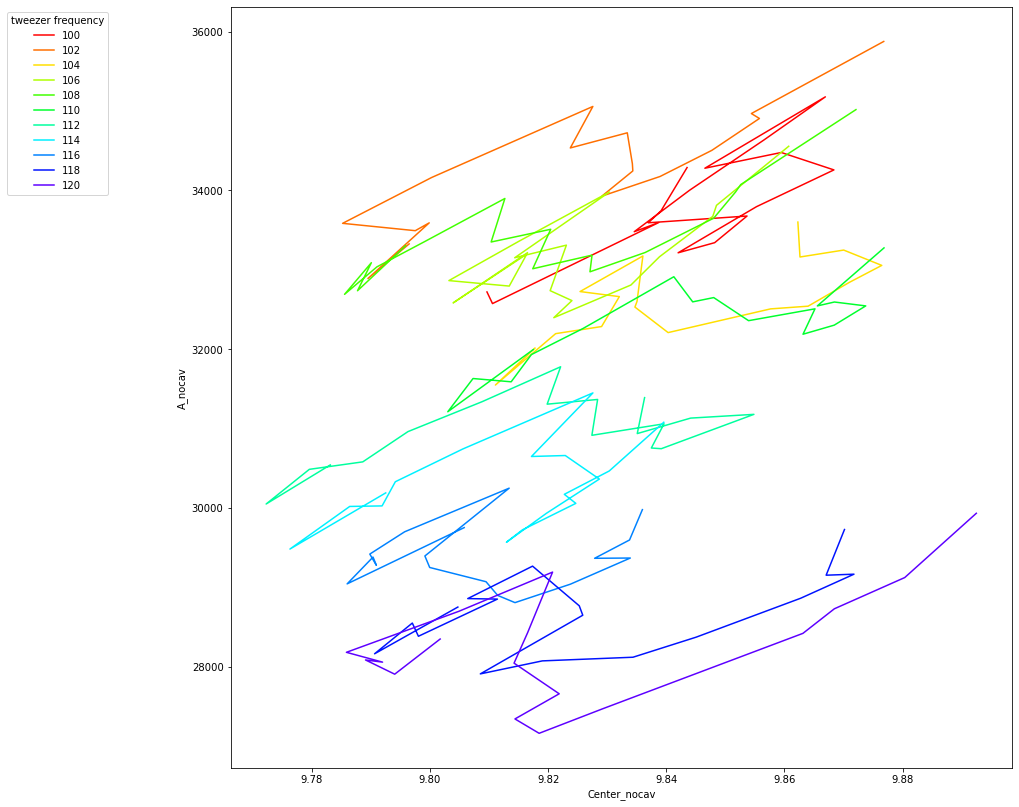

In [12]:
 
fig, ax2 = plt.subplots(1, 1,  figsize=(14, 14))
ax2.set_xlabel('Center_nocav')
ax2.set_ylabel('A_nocav') 
starkshift_mean = np.zeros((len(tweezer_freq_list),num_loops))
starkshift_sigma = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_mean = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_sigma = np.zeros((len(tweezer_freq_list),num_loops))
for tweezer_counter in range(len(tweezer_freq_list)):
    for loop in range(num_loops):
        starkshift_mean[tweezer_counter, loop] = np.mean(starkshift_mov_avg[:, tweezer_counter, :, loop])
        starkshift_sigma[tweezer_counter, loop] = np.sqrt(np.std(starkshift_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_starkshift_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))
        mol_brightness_mean[tweezer_counter, loop] = np.mean(mol_brightness_mov_avg[:, tweezer_counter, :, loop])
        mol_brightness_sigma[tweezer_counter, loop] = np.sqrt(np.std(mol_brightness_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_mol_brightness_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))

    colorratio = tweezer_counter/len(tweezer_freq_list)
    color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
        
#     ax2.errorbar(starkshift_mean[tweezer_counter,:], mol_brightness_mean[tweezer_counter,:], \
#        xerr = starkshift_sigma[tweezer_counter,:], yerr = mol_brightness_sigma[tweezer_counter,:], \
#                  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}'\
#                 , color=color)
    ax2.plot(starkshift_mean[tweezer_counter,::10], mol_brightness_mean[tweezer_counter,::10], \
                color=color , label= f'{tweezer_freq_list[tweezer_counter]}')
    
ax2.legend(title='tweezer frequency', bbox_to_anchor=(-0.15, 1), loc='upper right')

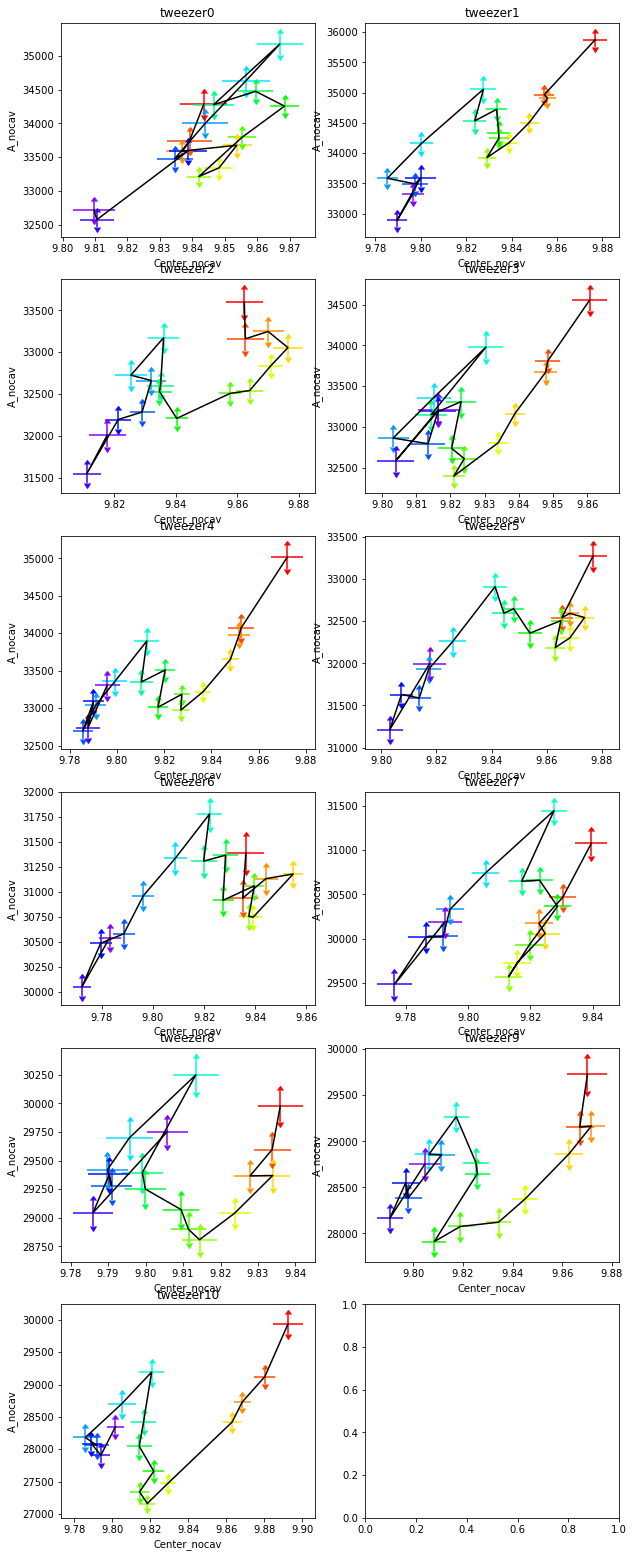

In [20]:
 
fig, ax3 = plt.subplots((num_tweezers+1)//2, 2,  figsize=(10, 10*num_tweezers/4))
starkshift_mean = np.zeros((len(tweezer_freq_list),num_loops))
starkshift_sigma = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_mean = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_sigma = np.zeros((len(tweezer_freq_list),num_loops))
for tweezer_counter in range(len(tweezer_freq_list)):
    ax3[tweezer_counter//2,tweezer_counter%2].set_xlabel('Center_nocav')
    ax3[tweezer_counter//2,tweezer_counter%2].set_ylabel('A_nocav') 
    ax3[tweezer_counter//2,tweezer_counter%2].set_title(f'tweezer{tweezer_counter}') 
    for loop in range(0,num_loops,10):
        starkshift_mean[tweezer_counter, loop] = np.mean(starkshift_mov_avg[:, tweezer_counter, :, loop])
        starkshift_sigma[tweezer_counter, loop] = np.sqrt(np.std(starkshift_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_starkshift_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))
        mol_brightness_mean[tweezer_counter, loop] = np.mean(mol_brightness_mov_avg[:, tweezer_counter, :, loop])
        mol_brightness_sigma[tweezer_counter, loop] = np.sqrt(np.std(mol_brightness_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_mol_brightness_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))

        colorratio = loop/num_loops
        color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
        
        ax3[tweezer_counter//2,tweezer_counter%2].errorbar(starkshift_mean[tweezer_counter,loop], mol_brightness_mean[tweezer_counter,loop], \
           xerr = starkshift_sigma[tweezer_counter,loop]/ 10, yerr = mol_brightness_sigma[tweezer_counter,loop]/10, \
                     uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}'\
                    , color=color)
    
    ax3[tweezer_counter//2,tweezer_counter%2].plot(starkshift_mean[tweezer_counter,::10], mol_brightness_mean[tweezer_counter,::10], \
                color='black' , label= f'{tweezer_freq_list[tweezer_counter]}')

In [ ]:
 
fig, ax3 = plt.subplots((num_tweezers+1)//2, 2,  figsize=(10, 10*num_tweezers/4))
starkshift_mean = np.zeros((len(tweezer_freq_list),num_loops))
starkshift_sigma = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_mean = np.zeros((len(tweezer_freq_list),num_loops))
mol_brightness_sigma = np.zeros((len(tweezer_freq_list),num_loops))
for tweezer_counter in range(len(tweezer_freq_list)):
    ax3[tweezer_counter//2,tweezer_counter%2].set_xlabel('Center_nocav')
    ax3[tweezer_counter//2,tweezer_counter%2].set_ylabel('A_nocav') 
    ax3[tweezer_counter//2,tweezer_counter%2].set_title(f'tweezer{tweezer_counter}') 
    for loop in range(0,num_loops,10):
        starkshift_mean[tweezer_counter, loop] = np.mean(starkshift_mov_avg[:, tweezer_counter, :, loop])
        starkshift_sigma[tweezer_counter, loop] = np.sqrt(np.std(starkshift_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_starkshift_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))
        mol_brightness_mean[tweezer_counter, loop] = np.mean(mol_brightness_mov_avg[:, tweezer_counter, :, loop])
        mol_brightness_sigma[tweezer_counter, loop] = np.sqrt(np.std(mol_brightness_mov_avg[:, tweezer_counter, :, loop])**2 \
        + np.mean(sigma_mol_brightness_mov_avg[:, tweezer_counter, :, loop]**2)/(len(pzt_para_list)*len(probe_att_list)))

        colorratio = loop/num_loops
        color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)
        
    ax3[tweezer_counter//2,tweezer_counter%2].errorbar(range(0,num_loops,10), brightness_mov_avg[tweezer_counter,loop], \
           xerr = starkshift_sigma[tweezer_counter,loop]/ 10, yerr = mol_brightness_sigma[tweezer_counter,loop]/10, \
                     uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}'\
                    , color=color)
    